In [1]:
import json
import torch
import joblib
import numpy as np
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
with open("train-claims.json", "r") as f:
    train_claims = json.load(f)

with open("evidence.json", "r") as f:
    evidence_data = json.load(f)

with open("filtered_retrieval_output.json", "r") as f:
    retrieval_data = json.load(f)

with open("dev-claims.json", "r") as f:
    dev_data = json.load(f)

In [3]:
embedder = SentenceTransformer("intfloat/e5-large-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [4]:
label_map = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
model = SentenceTransformer("intfloat/e5-large-v2")
X_texts, y_labels = [], []

for cid, entry in train_claims.items():
    claim_text = entry["claim_text"]
    label = entry["claim_label"]
    for evid_id in entry.get("evidences", []):
        if evid_id in evidence_data:
            ev_text = evidence_data[evid_id]
            X_texts.append(f"query: {claim_text} passage: {ev_text}")
            y_labels.append(label_map[label])

In [5]:
X_embeddings = model.encode(X_texts)
y_labels = np.array(y_labels)


X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

In [6]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

In [7]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(256,), max_iter=500, random_state=42)
clf.fit(X_train_bal, y_train_bal)

MLPClassifier(hidden_layer_sizes=(256,), max_iter=500, random_state=42)

In [8]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [9]:
y_pred = clf.predict(X_test)

inv_label_map = {v: k for k, v in label_map.items()}
print(classification_report(y_test, y_pred, target_names=[inv_label_map[i] for i in sorted(inv_label_map)]))

                 precision    recall  f1-score   support

       SUPPORTS       0.61      0.65      0.63       269
        REFUTES       0.69      0.24      0.35        92
NOT_ENOUGH_INFO       0.63      0.83      0.72       386
       DISPUTED       0.00      0.00      0.00        78

       accuracy                           0.63       825
      macro avg       0.48      0.43      0.43       825
   weighted avg       0.57      0.63      0.58       825



In [10]:
joblib.dump(clf, "logistic_model_improve.joblib")

['logistic_model_improve.joblib']

In [11]:
# Load trained classifier
clf = joblib.load("logistic_model_improve.joblib")

# Embed only claim_texts (without evidence)
dev_claim_ids = []
dev_claim_embeddings = []
for cid, data in dev_data.items():
    dev_claim_ids.append(cid)
    claim_text = data["claim_text"]
    dev_claim_embeddings.append(embedder.encode(f"query: {claim_text}"))

dev_claim_embeddings = np.array(dev_claim_embeddings)

# Predict using trained model
pred_labels = clf.predict(dev_claim_embeddings)
pred_label_names = [inv_label_map[label] for label in pred_labels]

predictions_without_retrieval = dict(zip(dev_claim_ids, pred_label_names))

# Save to file
with open("predictions_without_retrieval.json", "w") as f:
    json.dump(predictions_without_retrieval, f, indent=2)

print("Predictions without retrieval saved.")

Predictions without retrieval saved.


In [12]:
# Eveluating through retrieval outputs

label_map_rev = {0: "SUPPORTS", 1: "REFUTES", 2: "NOT_ENOUGH_INFO", 3: "DISPUTED"}

predictions = {}

for cid, entry in retrieval_data.items():
    claim_text = entry["claim_text"]
    evid_ids = entry["filtered_evidences"]

    evidence_texts = [evidence_data[eid] for eid in evid_ids if eid in evidence_data]
    if not evidence_texts:
        continue

    claim_vec = embedder.encode(f"query: {claim_text}")
    inputs = [f"query: {claim_text} passage: {ev}" for ev in evidence_texts]
    pair_vecs = embedder.encode(inputs)

    cos_scores = cosine_similarity([claim_vec], pair_vecs)[0]
    top_k = np.argsort(cos_scores)[-5:][::-1]

    top_vecs = [pair_vecs[i] for i in top_k]
    pred_probs = clf.predict_proba(top_vecs)
    avg_probs = np.mean(pred_probs, axis=0)
    final_label = label_map_rev[np.argmax(avg_probs)]
    top_evid_ids = [evid_ids[i] for i in top_k]

    predictions[cid] = {
        "claim_label": final_label,
        "evidences": top_evid_ids
    }

In [13]:
with open("predictions_eval_ready.json", "w") as f:
    json.dump(predictions, f, indent=2)

print("Saved predictions to predictions_eval_ready.json")

Saved predictions to predictions_eval_ready.json


In [14]:
!python eval.py --predictions predictions_eval_ready.json --groundtruth dev-claims.json

Evidence Retrieval F-score (F)    = 0.13520923520923522
Claim Classification Accuracy (A) = 0.42207792207792205
Harmonic Mean of F and A          = 0.20480943189384412


# Eveluation

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [17]:
# Compare with dev_claims' labels
y_true = [label_map[claim["claim_label"]] for claim in dev_data.values()]
claim_texts = [claim["claim_text"] for claim in dev_data.values()]
claim_ids = list(dev_data.keys())
claim_evidence_ids = [claim["evidences"] for claim in dev_data.values()]

print(classification_report(y_true, pred_labels, target_names=label_map.keys()))

                 precision    recall  f1-score   support

       SUPPORTS       0.71      0.32      0.44        68
        REFUTES       0.44      0.15      0.22        27
NOT_ENOUGH_INFO       0.29      0.80      0.43        41
       DISPUTED       0.00      0.00      0.00        18

       accuracy                           0.38       154
      macro avg       0.36      0.32      0.27       154
   weighted avg       0.47      0.38      0.35       154



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


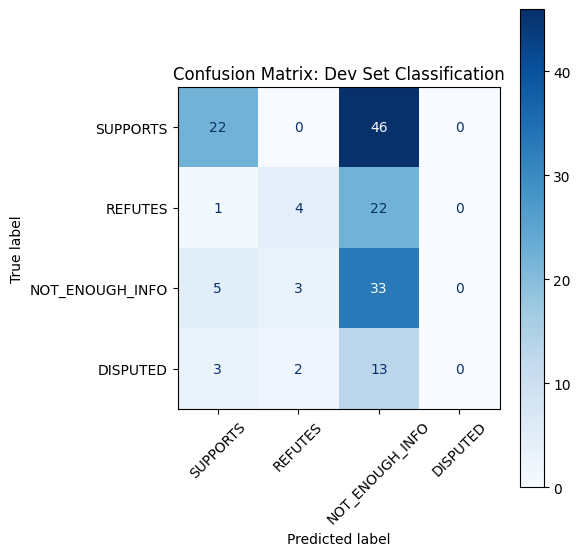

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, pred_labels)
labels = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix: Dev Set Classification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis Table
import pandas as pd
import random
from IPython.display import display, HTML

y_true = [label_map[claim["claim_label"]] for claim in dev_data.values()]
claim_texts = [claim["claim_text"] for claim in dev_data.values()]
claim_ids = list(dev_data.keys())
claim_evidence_ids = [claim["evidences"] for claim in dev_data.values()]

correct_preds = []
incorrect_preds = []

for i in range(len(y_true)):
    pred_label = pred_labels[i]
    true_label = y_true[i]
    evid_ids = claim_evidence_ids[i]
    evid_texts = [evidence_data[eid] for eid in evid_ids if eid in evidence_data]
    snippet = evid_texts[0][:200] if evid_texts else "N/A"

    row = {
        "Claim": claim_texts[i],
        "True Label": inv_label_map[true_label],
        "Predicted": inv_label_map[pred_label],
        "Evidence Snippet": snippet,
        "Correct?": "✔️" if true_label == pred_label else "❌"
    }

    if true_label == pred_label:
        correct_preds.append(row)
    else:
        incorrect_preds.append(row)

random.seed(42)
sample_correct = random.sample(correct_preds, min(10, len(correct_preds)))
sample_incorrect = random.sample(incorrect_preds, min(10, len(incorrect_preds)))

mixed_sample = sample_correct + sample_incorrect
random.shuffle(mixed_sample)

mixed_df = pd.DataFrame(mixed_sample)
pd.set_option('display.max_colwidth', 120)

display(HTML("<h3>Mixed Prediction Sample (Correct ✔️ & Incorrect ❌)</h3>"))
display(mixed_df)

,Claim,True Label,Predicted,Evidence Snippet,Correct?
0,"The corals may save themselves, as many other creatures are attempting to do, by moving toward the poles as the Eart...",SUPPORTS,NOT_ENOUGH_INFO,"The poleward migration of coral species refers to the phenomenon brought on by rising sea temperatures, wherein cora...",❌
1,Lake-bottom sediments in Florida tell us that recent major hurricane activity in the Gulf of Mexico has been less fr...,REFUTES,NOT_ENOUGH_INFO,Few major hurricanes struck the Gulf coast during 3000–1400 BC and again during the most recent millennium.,❌
2,"Renew­ables such as wind turbines are environmentally disastrous because they pollute a huge land area, slice and di...",REFUTES,SUPPORTS,"Fossil-fueled power plants, which wind turbines generally require to make up for their weather dependent intermitten...",❌
3,'Another global warming myth comes crashing down.,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,Henderson asserts that a decline in the number of pirates over the years is the cause of global warming.,✔️
4,Global Warming history completely coincides with the history of artificial satellites and the use of microwave frequ...,NOT_ENOUGH_INFO,SUPPORTS,"Over time, a massive system of artificial satellites was placed into orbit around Earth.",❌
5,"The CO2 amplifies the warming and mixes through the atmosphere, spreading warming throughout the planet.",SUPPORTS,SUPPORTS,The greenhouse effect is a process by which thermal radiation from a planetary atmosphere warms the planet's surface...,✔️
6,The amount of carbon dioxide absorbed by the upper layer of the oceans is increasing by about 2 billion tons per year.,NOT_ENOUGH_INFO,SUPPORTS,"Human activities emit about 29 billion tons of carbon dioxide per year, while volcanoes emit between 0.2 and 0.3 bil...",❌
7,"“In their award winning book, ‘Taken By Storm’ (2007), Canadian researchers Christopher Essex and Ross McKitrick exp...",NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,"Lately, the temperature criterion has fallen out of the definition across the United States Bomb cyclone – A rapid d...",✔️
8,"The broader term covers changes beyond warmer temperatures, such as shifting rainfall patterns.”",SUPPORTS,NOT_ENOUGH_INFO,Climate change is more accurate scientifically to describe the various effects of greenhouse gases on the world beca...,❌
9,CO2 limits won't cool the planet.,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,"Less energy reaches the upper atmosphere, which is therefore cooler because of this absorption.",✔️


In [35]:
mixed_df.to_csv("mixed_predictions_analysis.csv", index=False)

# Modified Dataset Pipeline

In [ ]:
# Use only the claim_text as input
X_new_texts = []
y_new_labels = []

for item in train_claims.values():
    X_new_texts.append(item["claim_text"])
    y_new_labels.append(label_map[item["claim_label"]])

# Use SentenceTransformer to embed
X_new_embeddings = embedder.encode(X_new_texts, convert_to_numpy=True, show_progress_bar=True)

# Use claim-to-claim k-NN voting (no evidence needed)
train_embeddings = embedder.encode(X_new_texts, convert_to_numpy=True, show_progress_bar=True)
train_labels = y_new_labels 

test_texts = [item["claim_text"] for item in dev_data.values()]
test_ids = list(dev_data.keys())
test_embeddings = embedder.encode(test_texts, convert_to_numpy=True, show_progress_bar=True)

# Use cosine similarity for k-NN majority voting
from collections import Counter
def knn_majority_vote(test_vec, train_vecs, train_labels, k=5):
    sims = cosine_similarity([test_vec], train_vecs)[0]
    top_k_indices = sims.argsort()[-k:][::-5]
    top_k_labels = [train_labels[i] for i in top_k_indices]
    most_common = Counter(top_k_labels).most_common(1)[0][0]
    return most_common

# Predict labels for all claims
pred_labels_knn = [knn_majority_vote(test_vec, train_embeddings, train_labels, k=5) for test_vec in test_embeddings]

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
# Evaluate
y_true0 = [label_map[item["claim_label"]] for item in dev_data.values()]
print(classification_report(y_true0, pred_labels_knn, target_names=label_map.keys()))

                 precision    recall  f1-score   support

       SUPPORTS       0.63      0.69      0.66        68
        REFUTES       0.42      0.48      0.45        27
NOT_ENOUGH_INFO       0.45      0.34      0.39        41
       DISPUTED       0.29      0.28      0.29        18

       accuracy                           0.51       154
      macro avg       0.45      0.45      0.45       154
   weighted avg       0.50      0.51      0.51       154



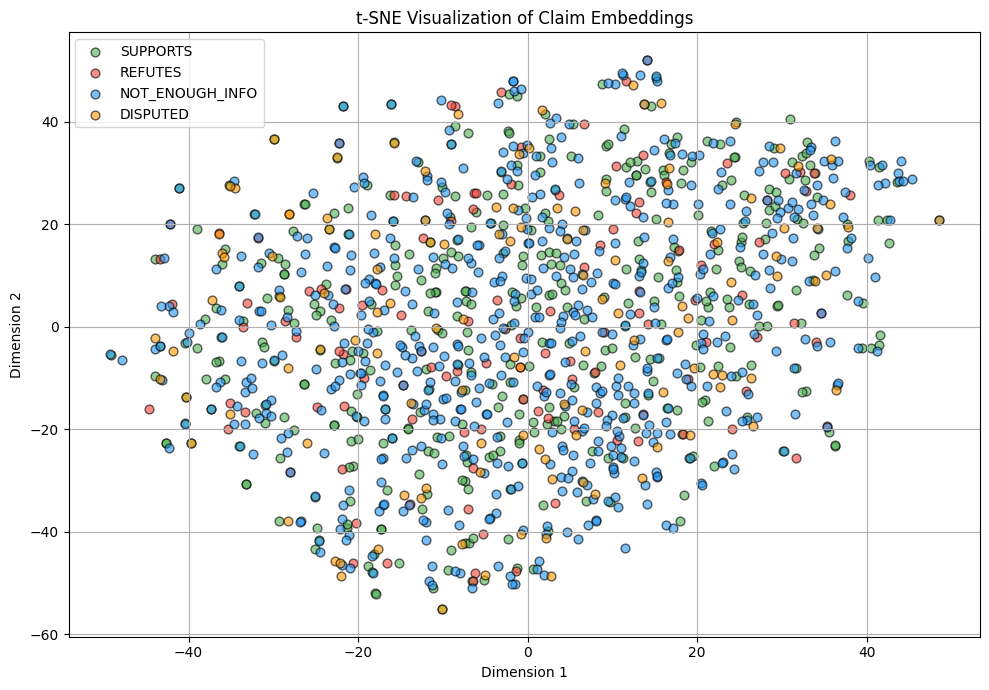

In [ ]:
# t-SNE
from sklearn.manifold import TSNE

num_points = min(len(X_tsne), len(y_labels))
X_tsne = X_tsne[:num_points]
label_names = [inv_label_map[y] for y in y_labels[:num_points]]

plt.figure(figsize=(10, 7))

for label in label_map.keys():
    idxs = [i for i, l in enumerate(label_names) if l == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1],
                c=colors[label], label=label, alpha=0.6, edgecolors='k', s=40)

plt.title("t-SNE Visualization of Claim Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()